In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates ## Formatear las fechas en el eje x para mostrar solo horas, minutos y segundos
import os
from datetime import datetime, timedelta, time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Data

In [2]:
# Se crea un diccionario para almacenar los marcos de datos.
dataframes = {}

data_folder = os.path.join('..','Date') #creamos el path

#verificamos que el path sea correcto y en caso que asi sea, vemos los nombres de archivos dentro
if os.path.isdir(data_folder):
    files = os.listdir(data_folder) # guardamos la lista
    print(files)

# Se define una función para leer cada archivo y convertirlo en un dataframe
def read_file(filename):
    df = pd.read_excel(os.path.join(data_folder,filename))
    dataframes[filename] = df #Se crea un elemento del diccionario -> dataframa[CLAVE] = VALOR

#Leo todos los archivos excel
for filename in files:
    read_file(filename)

['Medicion 01-12-2023.xlsx', 'Medicion 02-03-2024.xlsx', 'Medicion 11-03.xlsx', 'Medicion 15-12-2023.xlsx', 'Medicion 19-04.xlsx', 'Medicion 22-04-2024.xlsx', 'Medicion 27-05.xlsx', 'Medicion 28-05.xlsx', 'Medicion 28-12-2023.xlsx', 'Medicion 29-04-2024.xlsx', 'Medicion 30-04-2024.xlsx']


In [3]:
# Lista para almacenar los DataFrames de Temperaturas
df_list = []
# Lista para almacenar los DataFrames de DateTime
df_date_list = []

for filename in files:
    # Suponiendo que tienes un DataFrame llamado dataframes y un nombre de archivo filename
    # Primero, convierte la columna "Date" en datetime
    dataframes[filename]['Date'] = pd.to_datetime(dataframes[filename]['Date'], errors='coerce')
    # Elimino las filas con NaT en la columna "Date" como referencia.
    dataframes[filename] = dataframes[filename].dropna(subset=['Date'])
    #dataframes[filename] = dataframes[filename].dropna(subset=['T1grasa'])
    # Selecciono las columnas 3 a 11, columnas de temperaturas. Lo guardo en un nuevo datafrema df.
    df = dataframes[filename].iloc[:, 3:12]
    #Sustituyo la columna "Date"(fecha) por una columna datetime donde tengo la fecha y hora.
    dataframes[filename]["Date"]=pd.to_datetime(dataframes[filename]["Date"].dt.strftime('%Y-%m-%d') + ' ' + dataframes[filename]["Time"].astype(str))
    #Inserto la clumna Date en el dataframe df. No utiilio df["Date"]=valor porque este me inserta la columna al final
    df_date = dataframes[filename]["Date"]
     # Agregar el DataFrame a la lista de DataFrame Temperaturas
    df_list.append(df)
    # Agregar el DataFrame a la lista de DataFrame DateTimes
    df_date_list.append(df_date)

In [4]:
#Acoto los datos a 300
num_datos = 300
for i, df in enumerate(df_list):
    df_list[i] = df[:num_datos]
    df_list[i] = df_list[i].bfill() #remplazo los valores nan por el siguiente
    df_date_list[i] = df_date_list[i][:num_datos]

C:\Users\angel\AppData\Local\Temp\ipykernel_7828\1284239033.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_list[i] = df_list[i].bfill() #remplazo los valores nan por el siguiente


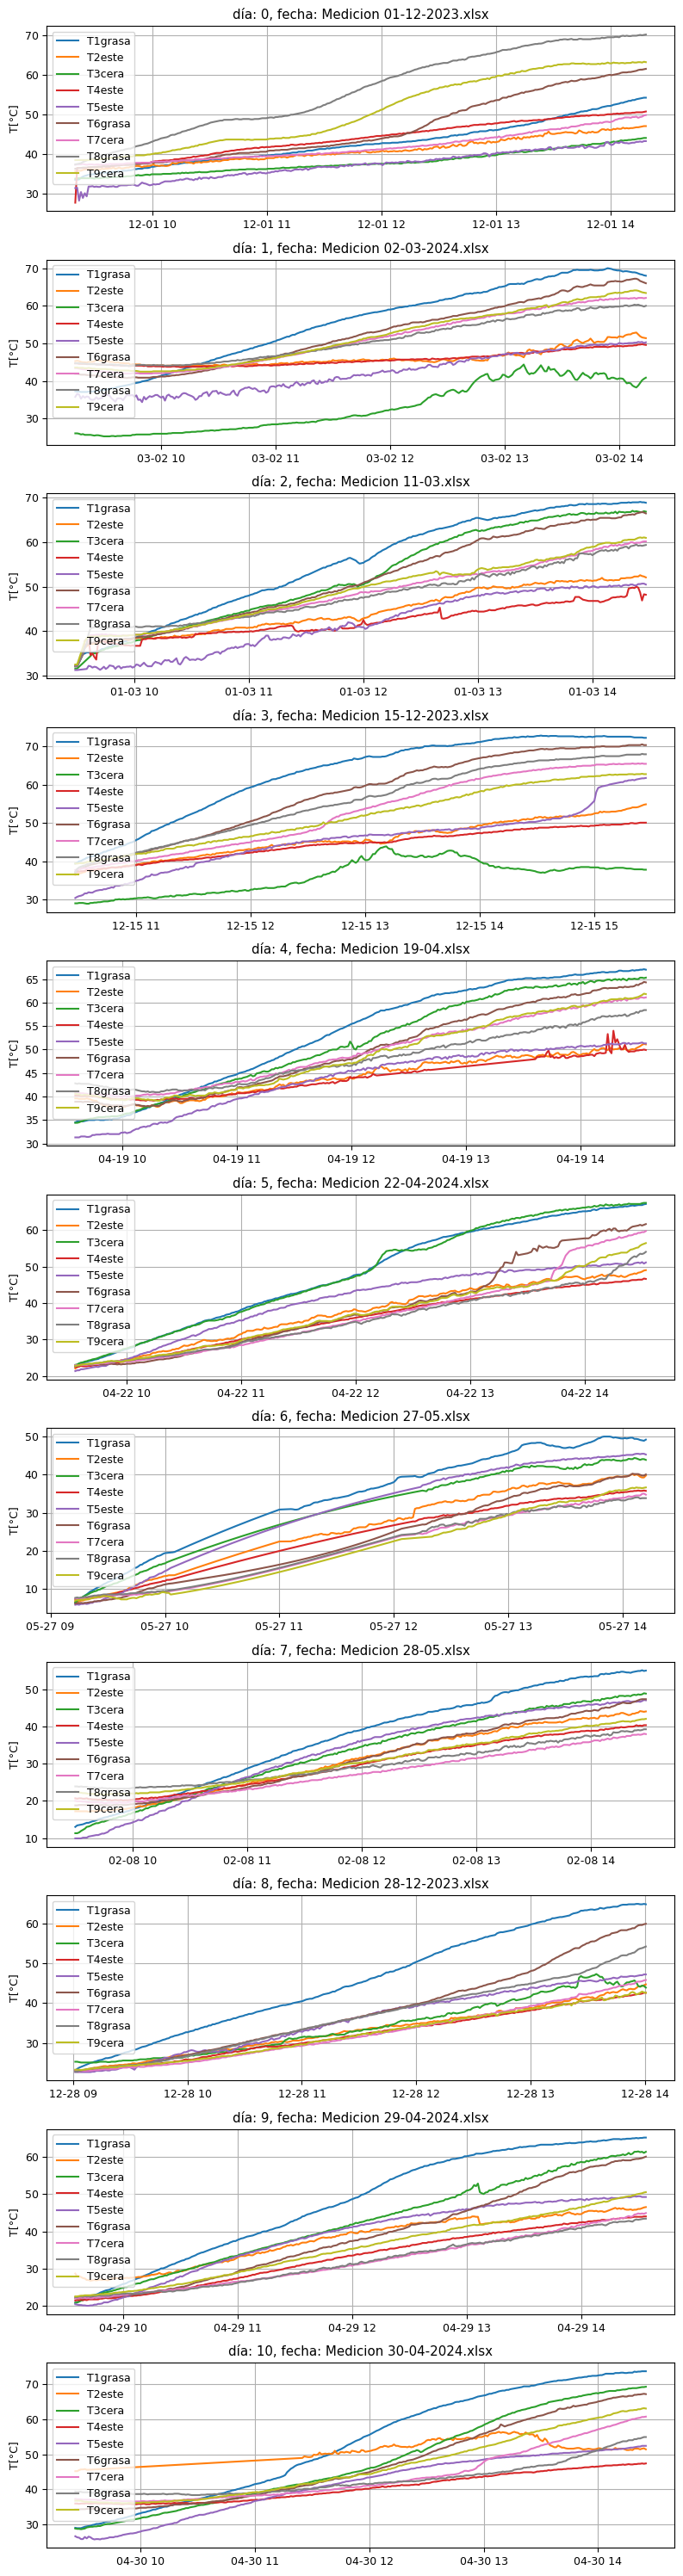

In [5]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 9}
plt.rc('font', **font)

fig, axs = plt.subplots(len(df_list),1, figsize=(8,30))
for i, df in enumerate(df_list): 
    axs[i].plot(df_date_list[i],df, '-', label = df.columns)
    axs[i].set_title(f"día: {i}, fecha: {files[i]}")
    axs[i].set_ylabel("T[°C]")
    axs[i].legend(loc = 'upper left')
    axs[i].grid()
fig.tight_layout()
plt.show()

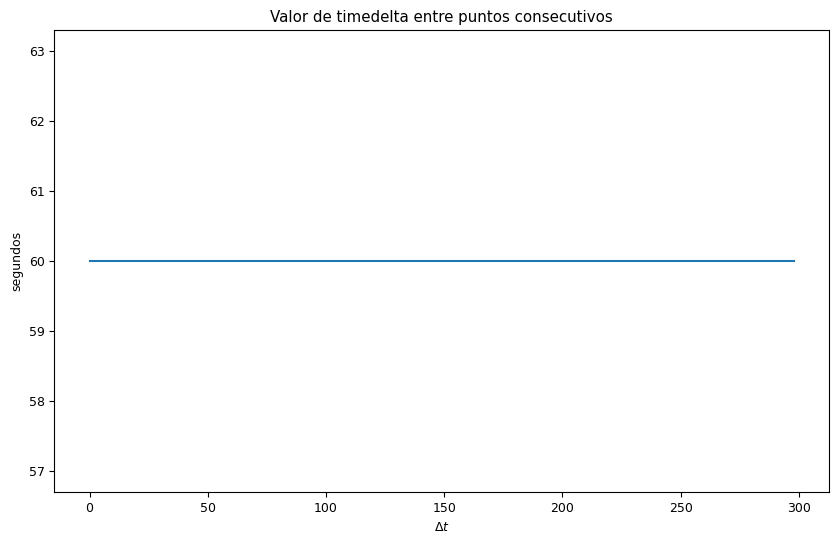

In [6]:
# verificamos que los datos estén completos
dt = np.array(df_date_list[1][1:], dtype = object)-np.array(df_date_list[1][:-1], dtype = object) 
#vector de deltas t. Diferencia del valor anterior con el siguiente.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title('Valor de timedelta entre puntos consecutivos')
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('segundos')
ax.plot([d.total_seconds() for d in dt]) 

Viendo la grafiaca, $\Delta t$ vale 60 seg. Es decir, se registra las variables cada una hora. Hay que corregir algunos dias, en los que los $\Delta t$ no son constantes.

## Autoencoder

El objetivo es usar un autoencoder para reducir la dimensionalidad de los datos de las series temporales y luego reconstruirlos, midiendo la pérdida (error) de reconstrucción para determinar cuántas magnitudes son necesarias para describir adecuadamente los datos.

In [7]:
#Modelo
class NN_deco(torch.nn.Module): 
    def __init__(self, n_in, latent_dim) -> None:
        super().__init__() 
        #contenedor encoder
        self. encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features= n_in, out_features= 128), 
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25), #desactiva algunas neuronas?
            torch.nn.Linear(in_features= 128, out_features= 64),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 64, out_features= 32),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 32, out_features= latent_dim)
        )

        #contenedor decoder
        self. decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features= latent_dim, out_features= 32),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 32, out_features= 64),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 64, out_features= 128),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 128, out_features= n_in)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

### Aplico a todas las curvas T

Organizo las curvas de temperatura de a 300

In [8]:
data = []
for df in df_list:
    for col in df:
        data.append(df[col])
data = np.array(data)
data.shape

(99, 300)

In [9]:
#a todos los datos sacale las medias x' = (x-mu)/sigma
scaler = StandardScaler()
data = scaler.fit_transform(data)
data.shape

(99, 300)

In [10]:
# Hyperparametros
input_dim = 300 #entradas
latent_dim = 1 #dimension del espacio latente. Cantidad de magnitudes o neuronas
num_epochs = 500 #Epocas
batch_size = 32 #cantidad de series o grupos qe se van a procesar
lr = 0.01 #taza de aprendizaje
dropout_act = False

# convertimos los datos a tensores
tensor_data= torch.tensor(data, dtype=torch.float32)
dataset = TensorDataset(tensor_data, tensor_data)  #El "objetivo" o "salida objetivo" es el mismo que el de entrada.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Inicializo el modelo, función de perdida y el optimizador
model = NN_deco(input_dim, latent_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
#Entrenamiento
history = []
model.train()
for epoch in range(num_epochs):
    for inputs, targets in dataloader: #target: "objetivos o "salida objetivo"
    
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.2041
Epoch [20/500], Loss: 0.0917
Epoch [30/500], Loss: 0.2338
Epoch [40/500], Loss: 0.0951
Epoch [50/500], Loss: 0.0620
Epoch [60/500], Loss: 0.0195
Epoch [70/500], Loss: 0.1134
Epoch [80/500], Loss: 0.4033
Epoch [90/500], Loss: 0.2035
Epoch [100/500], Loss: 0.0846
Epoch [110/500], Loss: 0.1033
Epoch [120/500], Loss: 0.0692
Epoch [130/500], Loss: 0.0648
Epoch [140/500], Loss: 0.0166
Epoch [150/500], Loss: 0.0386
Epoch [160/500], Loss: 0.0358
Epoch [170/500], Loss: 0.0682
Epoch [180/500], Loss: 0.0735
Epoch [190/500], Loss: 0.0515
Epoch [200/500], Loss: 0.0477
Epoch [210/500], Loss: 0.0749
Epoch [220/500], Loss: 0.0332
Epoch [230/500], Loss: 0.1962
Epoch [240/500], Loss: 0.0932
Epoch [250/500], Loss: 0.0429
Epoch [260/500], Loss: 0.0218
Epoch [270/500], Loss: 0.0511
Epoch [280/500], Loss: 0.0284
Epoch [290/500], Loss: 0.0563
Epoch [300/500], Loss: 0.1235
Epoch [310/500], Loss: 0.0560
Epoch [320/500], Loss: 0.0283
Epoch [330/500], Loss: 0.0540
Epoch [340/500], Lo

In [12]:
# Crear el directorio para guardar las imágenes si no existe
path_img = os.path.join("..","img","Datos","Autoencoder")
os.makedirs(path_img, exist_ok=True)

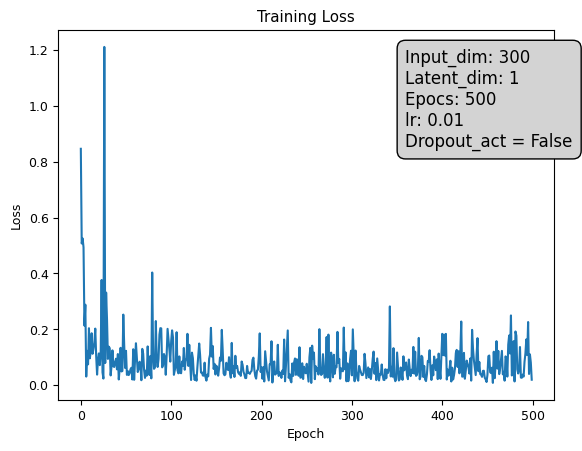

In [13]:
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
info_text = (
    f'Input_dim: {input_dim}\n'
    f'Latent_dim: {latent_dim}\n'
    f'Epocs: {num_epochs}\n'
    f'lr: {lr}\n'
    f'Dropout_act = {dropout_act}'
    )
plt.text(0.70, 0.95, info_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top',horizontalalignment='left',
         bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.savefig(os.path.join(path_img,"img4.png"), bbox_inches='tight')  # Guardar el gráfico en formato PNG
#plt.close()  # Cerrar la figura actual para liberar memoria
#plt.show()

In [14]:
# Se crea un diccionario para almacenar los marcos de datos.
dataframes = {}

data_folder = os.path.join('..','Date_Eval') #creamos el path

#verificamos que el path sea correcto y en caso que asi sea, vemos los nombres de archivos dentro
if os.path.isdir(data_folder):
    files = os.listdir(data_folder) # guardamos la lista
    print(files)

# Se define una función para leer cada archivo y convertirlo en un dataframe
def read_file(filename):
    df = pd.read_excel(os.path.join(data_folder,filename))
    dataframes[filename] = df #Se crea un elemento del diccionario -> dataframa[CLAVE] = VALOR

#Leo todos los archivos excel
for filename in files:
    read_file(filename)

['Medicion 11-03-2024.xlsx', 'Medicion 23-04-2024.xlsx']


In [15]:
# Lista para almacenar los DataFrames de Temperaturas
df_eval = []
# Lista para almacenar los DataFrames de DateTime
date_eval_list = []

for filename in files:
    # Suponiendo que tienes un DataFrame llamado dataframes y un nombre de archivo filename
    # Primero, convierte la columna "Date" en datetime
    dataframes[filename]['Date'] = pd.to_datetime(dataframes[filename]['Date'], errors='coerce')
    # Elimino las filas con NaT en la columna "Date" como referencia.
    dataframes[filename] = dataframes[filename].dropna(subset=['Date'])
    #dataframes[filename] = dataframes[filename].dropna(subset=['T1grasa'])
    # Selecciono las columnas 3 a 11, columnas de temperaturas. Lo guardo en un nuevo datafrema df.
    df = dataframes[filename].iloc[:, 3:12]
    #Sustituyo la columna "Date"(fecha) por una columna datetime donde tengo la fecha y hora.
    dataframes[filename]["Date"]=pd.to_datetime(dataframes[filename]["Date"].dt.strftime('%Y-%m-%d') + ' ' + dataframes[filename]["Time"].astype(str))
    #Inserto la clumna Date en el dataframe df. No utiilio df["Date"]=valor porque este me inserta la columna al final
    df_date = dataframes[filename]["Date"]
     # Agregar el DataFrame a la lista de DataFrame Temperaturas
    df_eval.append(df)
    # Agregar el DataFrame a la lista de DataFrame DateTimes
    date_eval_list.append(df_date)

In [16]:
#Acoto los datos a 300
num_datos = 300
for i, df in enumerate(df_eval):
    df_eval[i] = df[:num_datos]
    df_eval[i] = df_list[i].bfill() #remplazo los valores nan por el siguiente
    #df_date_list[i] = df_date_list[i][:num_datos]

In [19]:
df_eval[1]

,T1grasa,T2este,T3cera,T4este,T5este,T6grasa,T7cera,T8grasa,T9cera
0,37.3,45.3,26.1,44.7,35.8,41.9,43.4,44.7403,43.6
1,37.2,45.4,26.1,44.7,36.6,41.9,43.4,44.7403,43.6
2,37.2,45.3,26.0,44.6,36.4,41.8,43.3,44.7066,43.5
3,37.1,45.1,25.8,44.6,35.3,41.7,43.2,44.6739,43.5
4,37.1,45.0,25.9,44.6,36.0,41.7,43.1,44.6422,43.5
...,...,...,...,...,...,...,...,...,...
295,68.6,52.4,38.8,49.7,50.4,67.0,62.1,60.3000,64.0
296,68.4,51.9,39.5,49.7,50.3,66.6,62.1,60.1000,63.8
297,68.3,51.6,40.2,49.8,50.4,66.4,62.1,60.0000,63.6
298,68.1,51.5,40.6,49.7,50.1,66.2,62.0,59.8000,63.5


### Pruebita con una sola curva T

In [27]:
scaler = StandardScaler()
d = scaler.fit_transform(df_eval[1]["T3cera"].to_numpy().reshape(1,-1))
d.shape

(1, 300)

In [28]:
d_tensor =torch.from_numpy(d).float() #convierto a tensor
model.eval()
x = model(d_tensor)
x.shape
x = x.detach().numpy()
x_inv  = scaler.inverse_transform(x)
x_inv = x_inv.reshape(-1,1)
x_inv.shape

(300, 1)

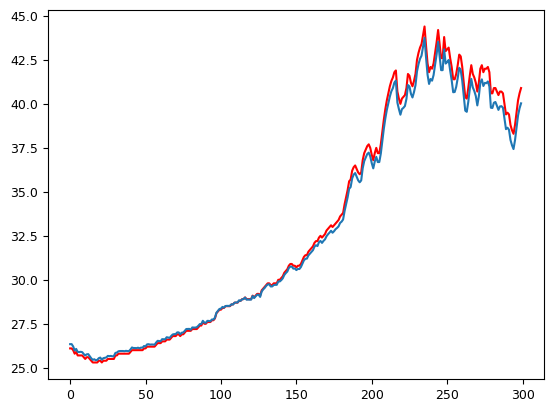

In [29]:
plt.plot(df_eval[1]["T3cera"], "r")
plt.plot(x_inv)